# Pneumonia detection
- classifying pneumonia from Chest x-ray image with CNN.
- data: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/data
- follow https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- use VGG16 weight. (Very Deep Convolutional Networks for Large-Scale Image Recognition
K. Simonyan, A. Zisserman
arXiv:1409.1556)

## load libraries and files

In [16]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img,img_to_array

import numpy as np 
import pandas as pd 
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline 

In [50]:
# data path
data_dir = Path('./chest_xray/')
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

## prepare train

In [68]:
def output_dataframe(path):
    '''
    This function produce dataframe of label with shuffling.
    
    input
    path: train, val or test directory
    
    output:
    dataframe for label
    
    '''
    
    n_dir = path / 'NORMAL'
    p_dir = path / 'PNEUMONIA'
    n_img = n_dir.glob('*.jpeg')
    p_img = p_dir.glob('*.jpeg')
    
    data = []

    for img in n_img:
        data.append((img,0))
    for img in p_img:
        data.append((img,1))
    
    # build dataframe
    data = pd.DataFrame(data,
                          columns=['image','label'],index=None)
    #data = data.sample(frac=1.).reset_index(drop=True)
    
    return data

In [97]:
# train
train_df = output_dataframe(train_dir)
train_df.head()

,image,label
0,chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg,0
1,chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg,0
2,chest_xray/train/NORMAL/IM-0427-0001.jpeg,0
3,chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg,0
4,chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg,0


In [98]:
train_df.label.value_counts()

1    3875
0    1341
Name: label, dtype: int64

In [99]:
# validation set
val_df = output_dataframe(val_dir)
val_df.head()

,image,label
0,chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg,0
1,chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg,0
2,chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg,0
3,chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg,0
4,chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg,0


In [100]:
val_df.label.value_counts()

1    8
0    8
Name: label, dtype: int64

In [101]:
# test set
test_df = output_dataframe(test_dir)
test_df.head()

,image,label
0,chest_xray/test/NORMAL/IM-0031-0001.jpeg,0
1,chest_xray/test/NORMAL/IM-0025-0001.jpeg,0
2,chest_xray/test/NORMAL/NORMAL2-IM-0272-0001.jpeg,0
3,chest_xray/test/NORMAL/NORMAL2-IM-0102-0001.jpeg,0
4,chest_xray/test/NORMAL/NORMAL2-IM-0229-0001.jpeg,0


In [102]:
test_df.label.value_counts()

1    390
0    234
Name: label, dtype: int64

## explore images and labels

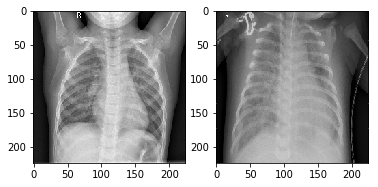

In [4]:
f_normal = './chest_xray/train/NORMAL/IM-0115-0001.jpeg'
f_pneumonia = './chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'

plt.subplot(121)
plt.imshow(load_img(f_normal, target_size=(224, 224)))
plt.subplot(122)
plt.imshow(load_img(f_pneumonia, target_size=(224, 224)))


#original = load_img(f_normal, target_size=(224, 224))

## can you tell?

## run through cnn

In [106]:
img_width, img_height = 150,150
nb_train_samples = train_data.shape[0]
nb_validation_samples = val_data.shape[0]
epochs = 10
batch_size = 16

In [85]:
## run image through the model and save feature output
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        val_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save('bottleneck_features_validation.npy',
            bottleneck_features_validation)
    print('val done')
    generator = datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save('bottleneck_features_train.npy',
            bottleneck_features_train)



## train top layer

In [107]:
def train_top_model():
    train_data = np.load('bottleneck_features_train.npy')
    #train_labels = np.array(
    #    [0] * (nb_train_samples / 2) + [1] * (nb_train_samples / 2))
    train_labels = train_df.label.values

    validation_data = np.load('bottleneck_features_validation.npy')
    validation_labels = val_df.label.values
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)

## evaluate

In [86]:
# # only do it one time.
# import time

# start_time = time.time()

# save_bottlebeck_features()

# print(time.time() - start_time, "seconds")


Found 16 images belonging to 2 classes.
val done
Found 5216 images belonging to 2 classes.
1713.0858130455017 seconds


In [108]:
train_top_model()

Train on 5216 samples, validate on 16 samples
Epoch 1/10
5216/5216 [==============================] - 11s 2ms/step - loss: 0.2395 - acc: 0.9097 - val_loss: 0.3702 - val_acc: 0.8750
Epoch 2/10
5216/5216 [==============================] - 11s 2ms/step - loss: 0.1265 - acc: 0.9521 - val_loss: 0.5624 - val_acc: 0.8125
Epoch 3/10
5216/5216 [==============================] - 12s 2ms/step - loss: 0.1117 - acc: 0.9599 - val_loss: 0.3757 - val_acc: 0.8750
Epoch 4/10
5216/5216 [==============================] - 12s 2ms/step - loss: 0.1005 - acc: 0.9651 - val_loss: 0.3739 - val_acc: 0.8750
Epoch 5/10
5216/5216 [==============================] - 14s 3ms/step - loss: 0.0948 - acc: 0.9651 - val_loss: 0.1768 - val_acc: 0.9375
Epoch 6/10
5216/5216 [==============================] - 12s 2ms/step - loss: 0.0904 - acc: 0.9709 - val_loss: 0.5705 - val_acc: 0.8125
Epoch 7/10
5216/5216 [==============================] - 11s 2ms/step - loss: 0.0789 - acc: 0.9705 - val_loss: 0.2125 - val_acc: 0.9375
Epoch 8/1

NameError: name 'top_model_weights_path' is not defined

In [103]:
train_df.label.values

array([0, 0, 0, ..., 1, 1, 1])